## Import Libraries

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import zipfile
import re
import string
import nltk
import torch
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GlobalAveragePooling1D,GRU,LSTM,Bidirectional,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



## Data Downloading

In [3]:
zip_path = "/content/IMDB Dataset.csv.zip"
extract_to = "data/"
# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract specific files
    zip_ref.extract("IMDB Dataset.csv", extract_to)

In [4]:
train_data = pd.read_csv("data/IMDB Dataset.csv")
train_df, test_df = train_test_split(train_data, test_size=0.1, random_state=42)

In [5]:
# Tải stopwords nếu chưa có
nltk.download("stopwords")

# Khai báo stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Preprocessing

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["review"] = train_df["review"].apply(preprocess_text)
test_df["review"] = test_df["review"].apply(preprocess_text)

In [7]:
# separate review and sentiment
X_train = train_df["review"].values
y_train = train_df["sentiment"].values
X_test = test_df["review"].values
y_test = test_df["sentiment"].values

print("y_train type:", type(y_train))
print("Unique values in y_train:", np.unique(y_train))

# map 1->positive, 0->negative
if y_train.dtype == 'O':
    label_mapping = {'positive': 1, 'negative': 0}
    y_train = np.array([label_mapping[label] for label in y_train], dtype=np.float32)
    y_test = np.array([label_mapping[label] for label in y_test], dtype=np.float32)
else:
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

MAX_WORDS = 10000
MAX_LEN = 500

EMBEDDING_DIMS = 128

# Tokenize
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

y_train type: <class 'numpy.ndarray'>
Unique values in y_train: ['negative' 'positive']


## Build Model

#### Vanilla RNN Model

In [8]:
# Vanilla RNN model
def create_rnn_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIMS, mask_zero=True),  # mask_zero=True
        SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),  # return_sequences=False -> output 2D
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### GRU Model

In [10]:

# from tensorflow.keras.layers import GRU, Dense, Embedding, Bidirectional, BatchNormalization, Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# def create_gru_model():
#     model = Sequential([
#         # Embedding Layer với mask_zero để xử lý padding
#         Embedding(
#             input_dim=MAX_WORDS,
#             output_dim=EMBEDDING_DIMS,
#             input_length=MAX_LEN,
#             mask_zero=True
#         ),

#         # Stacked Bidirectional GRU Layers
#         GRU(
#             128,
#             return_sequences=True,
#             dropout=0.3,          # Dropout cho đầu vào
#             recurrent_dropout=0.2, # Dropout cho recurrent state
#             kernel_regularizer=l2(1e-4)
#         ),
#         BatchNormalization(),

#         GRU(
#             64,
#             return_sequences=False, # Layer cuối không cần return sequences
#             dropout=0.2,
#             recurrent_dropout=0.1
#         ),
#         Dropout(0.3),

#         # Hidden Layers với regularization
#         Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
#         BatchNormalization(),
#         Dropout(0.2),

#         # Output Layer
#         Dense(1, activation='sigmoid')
#     ])

#     # optimize
#     optimizer = Adam(
#         learning_rate=1e-3,
#         clipnorm=1.0  # avoid exploding gradients
#     )

#     model.compile(
#         optimizer=Adam(learning_rate=1e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_gru_model():
    model = Sequential([
        Embedding(
            input_dim=MAX_WORDS,
            output_dim=EMBEDDING_DIMS,
            input_length=MAX_LEN,
            mask_zero=True
        ),

        # Dropout cho embedding layer
        Dropout(0.3),

        # GRU Layer 1
        GRU(
            128,
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.2,
            kernel_regularizer=l2(1e-4)
        ),
        # GRU Layer 2
        GRU(
            64,
            dropout=0.2,
            recurrent_dropout=0.1
        ),

        # Hidden Layer với regularization
        Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.2),

        # Output Layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



#### LSTM Model

In [ ]:
# LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2

def create_lstm_model():
    model = Sequential([
        # Embedding with a slightly smaller dimension
        Embedding(input_dim=MAX_WORDS, output_dim=64, mask_zero=True),

        # Optimized bidirectional LSTM
        Bidirectional(LSTM(32, return_sequences=True)),
        BatchNormalization(),

        Bidirectional(LSTM(16)),
        Dropout(0.1),

        # Dense layers with reduced regularization
        Dense(16, activation="relu"),
        BatchNormalization(),

        # Output layer
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## Train Model

#### Train Vanilla RNN Model

In [ ]:
# Convert text data to sequences of integers using the tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


In [ ]:
# Train Vanilla RNN model
rnn_model = create_rnn_model()
X_train_tensor = np.array(X_train_pad, dtype=np.int32)
y_train_tensor = np.array(y_train, dtype=np.float32)
X_test_tensor = np.array(X_test_pad, dtype=np.int32)
y_test_tensor = np.array(y_test, dtype=np.float32)

# train model
history_rnn = rnn_model.fit(
    X_train_tensor, y_train_tensor,
    validation_data=(X_test_tensor, y_test_tensor),
    epochs=10, batch_size=64
)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.5109 - loss: 0.7080 - val_accuracy: 0.5530 - val_loss: 0.6767
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.5753 - loss: 0.6679 - val_accuracy: 0.6204 - val_loss: 0.6357
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.6675 - loss: 0.5992 - val_accuracy: 0.6878 - val_loss: 0.5853
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.7398 - loss: 0.5233 - val_accuracy: 0.7582 - val_loss: 0.5081
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.7864 - loss: 0.4610 - val_accuracy: 0.6426 - val_loss: 0.6189
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.7458 - loss: 0.5126 - val_accuracy: 0.7048 - val_loss: 0.5612
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.7502 - loss: 0.5089 - val_accuracy: 0.7570 - val_loss: 0.5203
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.7904 - loss: 0.4581 - 

#### Train GRU Model

In [12]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding để các chuỗi có cùng độ dài
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


In [ ]:
# Train GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
gru_model = create_gru_model()
history_gru = gru_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                            epochs=10, batch_size=128, callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1135s 3s/step - accuracy: 0.5632 - loss: 0.6936 - val_accuracy: 0.8274 - val_loss: 0.4037
Epoch 2/10
 57/352 ━━━━━━━━━━━━━━━━━━━━ 15:25 3s/step - accuracy: 0.8259 - loss: 0.4342

In [11]:
# Define tokenizer (adjust num_words if needed)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [ ]:
# Train LSTM model
lstm_model = create_lstm_model()
history_lstm = lstm_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                              epochs=5, batch_size=64, callbacks=[early_stopping])

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.5802 - loss: 0.7232 - val_accuracy: 0.8014 - val_loss: 0.4356
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.8419 - loss: 0.3690 - val_accuracy: 0.8756 - val_loss: 0.2940
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9048 - loss: 0.2465 - val_accuracy: 0.8870 - val_loss: 0.2760


### Plot results

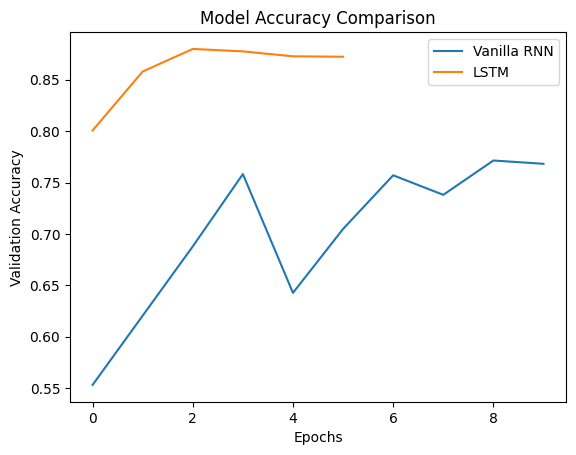

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_rnn.history['val_accuracy'], label="Vanilla RNN")
# plt.plot(history_gru.history['val_accuracy'], label="GRU")
plt.plot(history_lstm.history['val_accuracy'], label="LSTM")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Model Accuracy Comparison")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    """
    Plots training and validation accuracy over epochs.

    Parameters:
    history (dict or keras.callbacks.History):
        A dictionary or Keras History object containing 'accuracy' and 'val_accuracy'.
    """
    if hasattr(history, 'history'):  # If it's a Keras History object, extract history
        history = history.history

    epochs = range(1, len(history['accuracy']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='s')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_accuracy(model.history)  # If using Keras
# plot_accuracy({'accuracy': [...], 'val_accuracy': [...]})  # If using custom dictionary


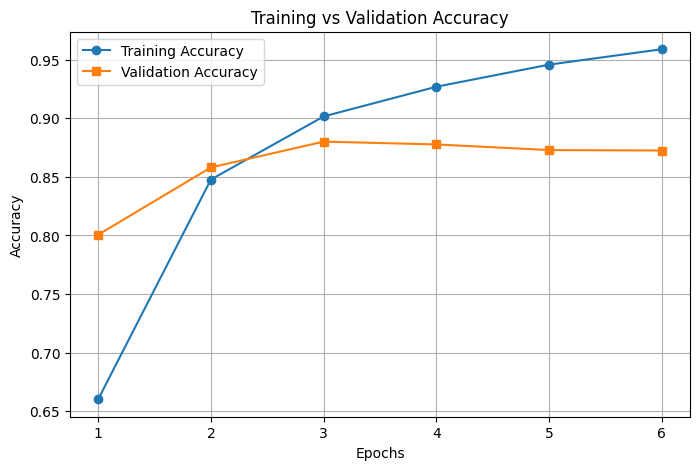

In [ ]:
plot_accuracy(lstm_model.history)

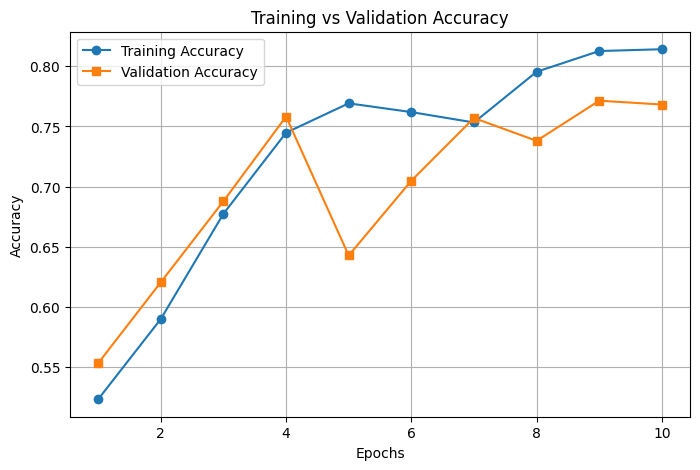

In [ ]:
plot_accuracy(rnn_model.history)